In [1]:
cd /home/dongdong/SCR/msm_pdz/isolation/charm36m

/scratch/gpfs/dongdong/msm_pdz/isolation/charm36m


In [9]:
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KCenters
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import MiniBatchKMedoids
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
from msmbuilder.lumping import PCCA
from msmbuilder.msm import implied_timescales
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=20)

In [8]:
font_path

'/home/disk2/wdd/msm/calibribold.ttf'

In [11]:
xyz = dataset("./trj/*.xtc",topology='crystal.pdb',stride=1)

In [12]:
minimal_inds = [a for a in xyz[0].topology.select_atom_indices(selection='minimal')]
trajs = [t.atom_slice(minimal_inds) for t in xyz]

In [13]:
cluster = MiniBatchKMedoids(metric='rmsd', n_clusters=800)

In [14]:
sequences = cluster.fit_transform(trajs)

KeyboardInterrupt: 

In [119]:
lag_times = np.arange(1,200,10)
n_timescales = 20

In [120]:
msm_timescales = implied_timescales(sequences, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)

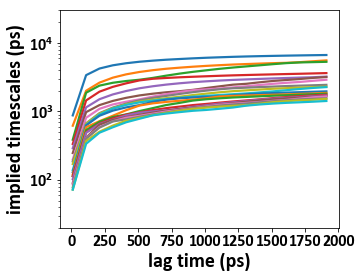

In [121]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*10, msm_timescales[:,i]*10,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ps)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ps)',fontproperties=font_prop)
plt.ylim(20,30000)
plt.semilogy()
plt.savefig('impliedtimescales_kmedoids_800.png',dpi=600,bbox_inches='tight')
plt.show()

In [131]:
msm=MarkovStateModel(lag_time=80,reversible_type='mle', verbose=False)

In [132]:
msm.fit(sequences)

MarkovStateModel(ergodic_cutoff='on', lag_time=80, n_timescales=None,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=False)

In [133]:
lab_fix=msm.transform(sequences,mode='fill')

In [100]:
len(lab_fix)

65

In [101]:
wf=open('Population.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()

In [103]:
import mdtraj.io as mdio
from msmbuilder.io import save_meta,load_meta
save_meta(sequences,'sequences.pickl')

In [104]:
save_meta(msm,'msm.pickl')

In [71]:
wf=open('xtc_sortname.cs','w')
for i in range(len(xyz)):
    wf.write(str(xyz.filename(i))+'\n')
wf.close()

In [191]:
nMacrostates = 20
lagT = 80
pcca = PCCAPlus.from_msm(msm, n_macrostates=nMacrostates)
macro_trajs = pcca.transform(lab_fix)

Optimization terminated successfully.
         Current function value: -12.235332
         Iterations: 28
         Function evaluations: 2203


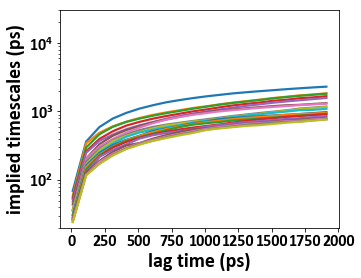

In [174]:
lag_times = np.arange(1,200,10)
n_timescales = 19
msm_timescales = implied_timescales(macro_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(reversible_type='mle',ergodic_cutoff='on',verbose=False), n_jobs = 4)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*10, msm_timescales[:,i]*10,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ps)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ps)',fontproperties=font_prop)
plt.ylim(20,30000)
plt.semilogy()
plt.savefig('Macro100_impliedtimescales_lag80.png',dpi=600,bbox_inches='tight')
plt.show()

In [192]:
Macromsm = MarkovStateModel(lag_time=80,ergodic_cutoff='on',reversible_type=None)
Macromsm.fit(macro_trajs)

MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=80, n_timescales=None,
         prior_counts=0, reversible_type=None, sliding_window=True,
         verbose=True)

In [176]:
wf=open('Macro_Population.dat','w')
for h in Macromsm.populations_:
    wf.write(str(float(h))+'\n')
wf.close()
from msmbuilder.tpt import mfpts
Macro_mfpt = mfpts(Macromsm)
wf=open('Macro_mfpt.dat','w')
for h in Macro_mfpt:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()
wf=open('tProb.mtx','w')
wf.write('%%MatrixMarket matrix coordinate real general\n%\n')
wf.write(str(len(Macromsm.transmat_))+' '+str(len(Macromsm.transmat_[0]))+' '+str(len(Macromsm.transmat_)*len(Macromsm.transmat_[0]))+'\n')
for i in range(len(Macromsm.transmat_)):
    for j in range(len(Macromsm.transmat_[i])):
        wf.write(str(i+1)+' '+str(j+1)+' '+str(Macromsm.transmat_[i][j])+'\n')
wf.close()

/home/disk2/software/anaconda2/envs/msmb/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [154]:
save_meta(Macromsm,'Macromsm.pickl')

In [155]:
save_meta(macro_trajs,'macro_trajs.pickl')

In [156]:
from msmbuilder.tpt import hub_scores

In [194]:
hubscore=hub_scores(Macromsm)

In [195]:
hubscore

array([ 0.05227246,  0.06302137,  0.06272927,  0.12309486,  0.14632596,
        0.18518435,  0.21719811,  0.20839705,  0.17365713,  0.25240428,
        0.41727728,  0.28290416,  0.37550175,  0.35876125,  0.46029329,
        0.70429881,  0.50321764,  0.58634329,  0.70235988,  0.79172357])

In [196]:
cd /home/disk2/wdd/PDZ/MSM/charm36m/Micro800_lag80/Macro20

/home/disk2/wdd/PDZ/MSM/charm36m/Micro800_lag80/Macro20


In [197]:
wf=open('Macro20_hubSoores.dat','w')
for h in hubscore:
    wf.write(str(h)+'\n')
wf.close()

In [162]:
cd /home/disk2/wdd/PDZ/MSM/charm36m/

/home/disk2/wdd/PDZ/MSM/charm36m


In [163]:
minimal_inds = [a for a in xyz[0].topology.select_atom_indices(selection='minima')]

ValueError: minima is not a valid option. Selection must be one of all, alpha, minimal, heavy, water

In [198]:
pwd

u'/home/disk2/wdd/PDZ/MSM/charm36m/Micro800_lag80/Macro20'

In [199]:
lab_traj=load_meta('macro_trajs.pickl')

In [201]:
M = load_meta('Macromsm.pickl')

In [213]:
cd /home/disk2/wdd/PDZ/MSM/charm36m/Micro800_lag80/Macro25/temp

/home/disk2/wdd/PDZ/MSM/charm36m/Micro800_lag80/Macro25/temp


In [206]:
from msmbuilder.featurizer import DihedralFeaturizer
xyz_trj = dataset("./*_sample.xtc",topology='crystal.pdb',stride=1)
featurizer_s = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_s = xyz_trj.fit_transform_with(featurizer_s, 'diheds_s/',fmt='dir-npy')

In [207]:
wf=open('xtc_sortname.cs','w')
for i in range(len(xyz_trj)):
    wf.write(str(xyz_trj.filename(i))+'\n')
wf.close()

In [208]:
xyz_c = dataset("./crystal.pdb",topology='crystal.pdb',stride=1)
featurizer_c = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_c = xyz_c.fit_transform_with(featurizer_c, 'diheds_c/',fmt='dir-npy')

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/mdtraj-1.8.0-py2.7-linux-x86_64.egg/mdtraj/core/trajectory.py:417: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')


In [214]:
#function of rmsd 
def singleSD(nList,refList):
    length=len(nList)
    sumVar=0.0
    for i in range(length):
        sub=nList[i]-refList[i]
        if np.abs(sub)>180:
            sub=360-np.abs(sub)
        sumVar+=sub**2
    return ((float(sumVar)/float((length)))**0.5)

In [215]:
crystral_dihed=diheds_c[0][0]/3.14*180
# rmsd of dihedral angle
wf=open('rmsd_dihed2.cs','w')
for i in range(25):
    allRmsd=0
    for j in range(len(diheds_s[i])):
        rmsd=singleSD(diheds_s[i][j]/3.14*180,crystral_dihed)
        allRmsd+=rmsd
    aveRmsd=allRmsd/float(len(diheds_s[i]))
    wf.write(str(i)+'    '+str(aveRmsd)+'\n')
wf.close()

In [212]:
#save dihedral angle
for i in range(25):
    wf=open(str(i)+'_dihed.cs','w')
    for j in range(len(diheds_s[i])):
        for k in range(len(diheds_s[i][j])):
            wf.write(str(diheds_s[i][j][k]/3.14*180)+'    ')
        wf.write('\n')
    wf.close()